# **CVPS20 // Edge Detection in Uniformly-Sampled Data**

*September 24, 2020*

In this notebook, we implement a series of ways of identifying sharp boundaries in both 1-dimensional and 2-dimensional data.

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as iio
from scipy.ndimage.filters import gaussian_filter as gf

<ipython-input-2-f38629e1fc13>:4: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter as gf


In [3]:
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gist_gray"

### Gradients as Edge Detectors

As before, let's define a clean and noisy step function,

In [4]:
# -- generate a smooth step function
xxc = np.linspace(-100., 100., 200)
yyc = 1.0 * (xxc > 20.)

# -- generate a noisy step function
np.random.seed(3597)
xxr = np.linspace(-100., 100., 50)
yyr = 1.0 * (xxr > 20.) + 0.2 * np.random.randn(xxr.size)

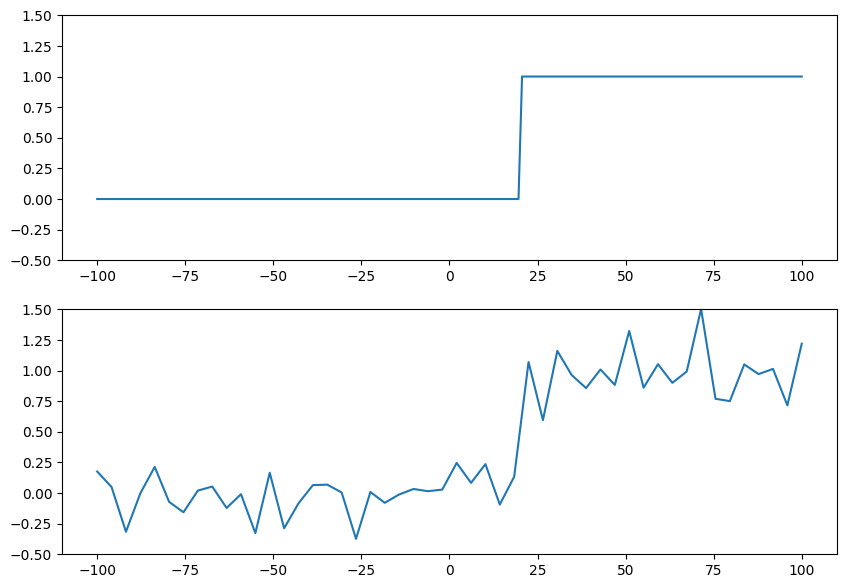

In [5]:
# -- plot the data sets
fig, ax = plt.subplots(2, 1)
ax[0].plot(xxc, yyc)
ax[1].plot(xxr, yyr)
ax[0].set_ylim(-0.5, 1.5)
ax[1].set_ylim(-0.5, 1.5)
fig.show()

Notice that these data sets both contain an "**edge**" at $x = 20$.  One way of detecting that edge in the clean case, is to simply take the difference between every successive point (closely related to the gradient),

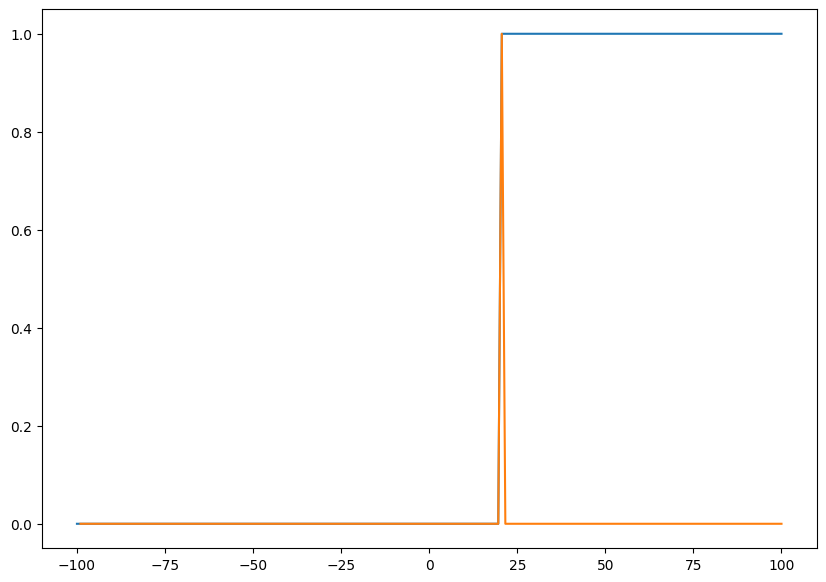

In [6]:
# -- take difference with each successive point of the clean step function
plt.plot(xxc, yyc)
plt.plot(xxc[1:], yyc[1:] - yyc[:-1])

In this clean case, the edge occurs where the gradient is non-zero.  But what about more complicated cases with noise and sampling that is more coarse?

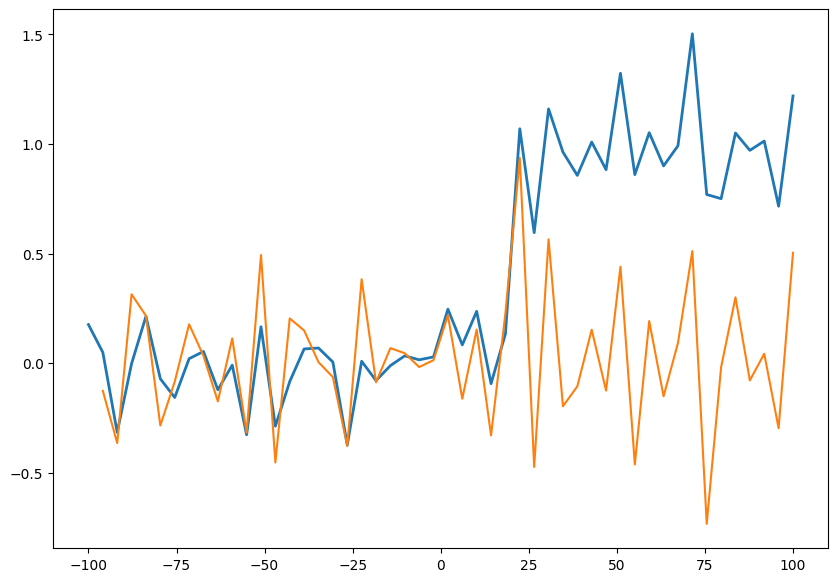

In [8]:
# -- take difference with each successive point of the noisy step function
plt.plot(xxr, yyr, lw=2)
plt.plot(xxr[1:], yyr[1:] - yyr[:-1])

The maximum of the gradient is still roughly at the edge location, but it is much more difficult to discern whether that maximum is sufficient to consitute an "edge".

Of course, we can do the same thing in 2D to attempt to find edges in images:

In [9]:
# -- read in an image
fname = "https://whyy.org/wp-content/uploads/2018/01/UD-pic-1-768x432.jpg"
img = np.asarray(iio.imread(fname)) / 255.

# -- create luminosity image
imgL = img.mean(axis=2)

<ipython-input-9-d68124688445>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = np.asarray(iio.imread(fname)) / 255.


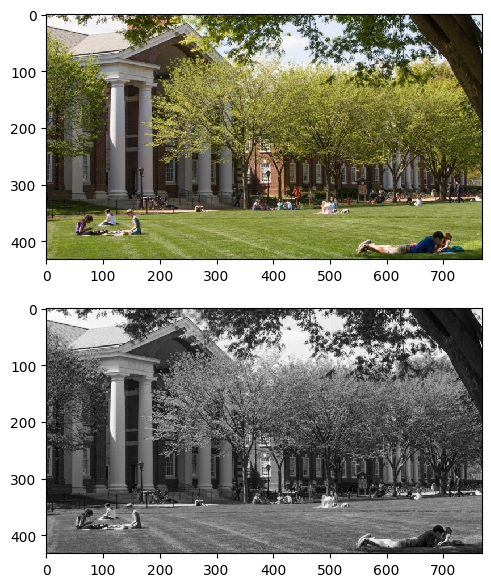

In [10]:
# -- plot it
fig, ax = plt.subplots(2, 1)
ax[0].imshow(img)
ax[1].imshow(imgL)
fig.show()

Shift each **row** by one **column** and subtract,

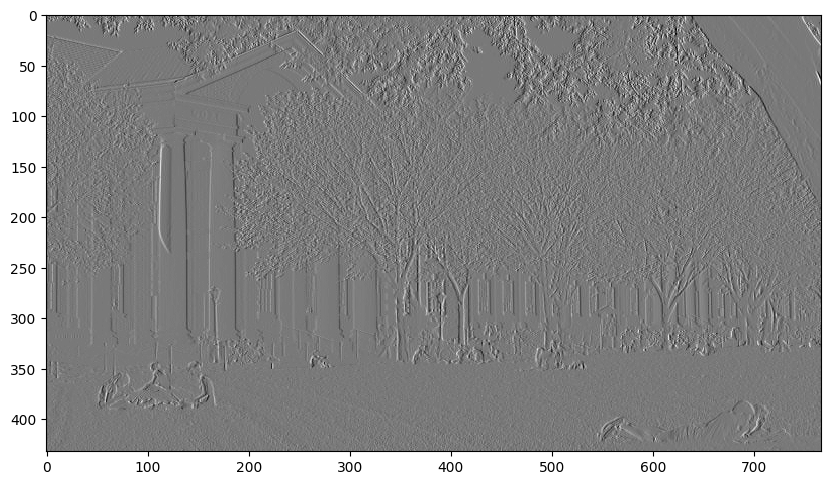

In [11]:
# -- take the column difference
plt.imshow(imgL[:, 1:] - imgL[:, :-1])

Or, shift by 1 **row** and subtract,

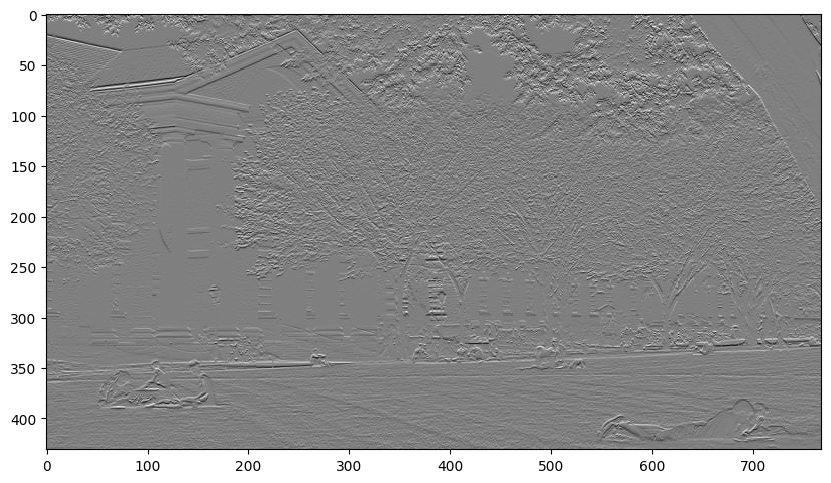

In [12]:
# -- row difference
plt.imshow(imgL[1:, :] - imgL[:-1, :])


This generates "gradients" in each direction, and we can get the "**gradient magnitude**",

In [13]:
# -- calculate gradient magnitude for a shift of some number of pixels
hor = imgL[1:-1, 1:-1] - imgL[1:-1, :-2]
ver = imgL[1:-1, 1:-1] - imgL[:-2, 1:-1]
tot = np.sqrt(hor**2 + ver**2)

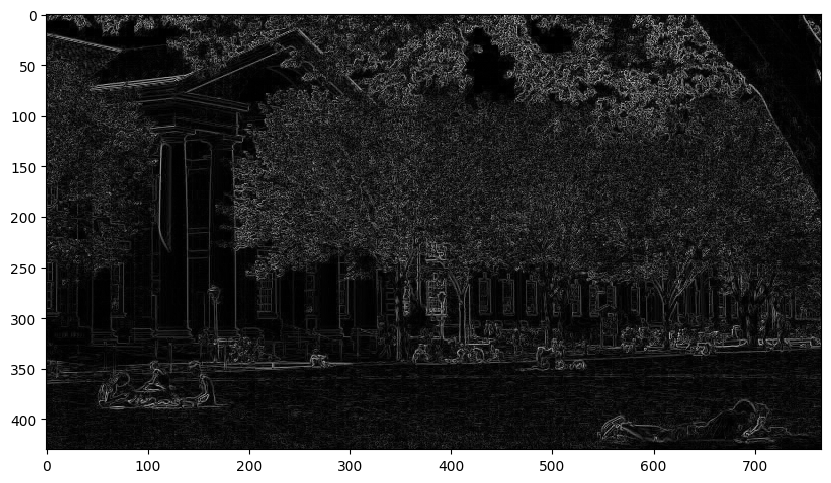

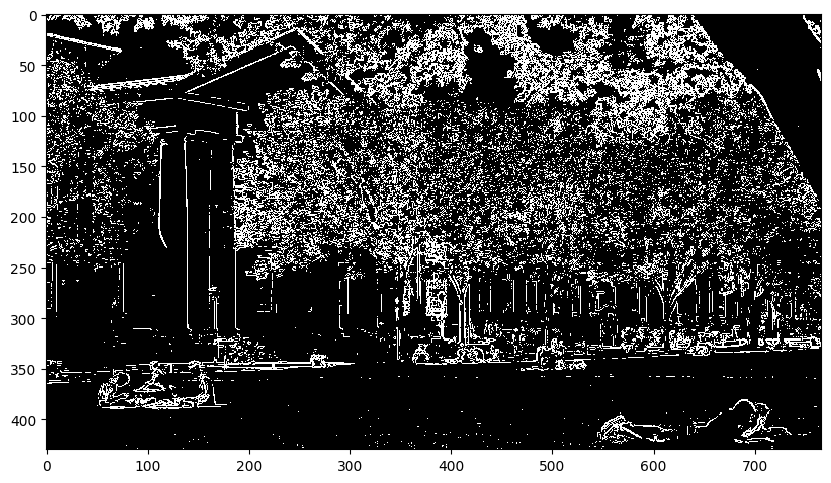

In [16]:
# -- plot it (and threshold)
plt.imshow(tot)
plt.figure()
plt.imshow(tot > 0.15)



What about an image with more subtle variations and lower resolution?

In [17]:
# -- load image and convert to float
fname = "/content/drive/My Drive/cvps20/data/examples/axons_eye.jpg"
axons = np.asarray(iio.imread(fname))[10:280, 10:350] / 255.

# -- create luminosity image
axonsL = axons.mean(axis=-1)

<ipython-input-17-61df1bbc2289>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  axons = np.asarray(iio.imread(fname))[10:280, 10:350] / 255.


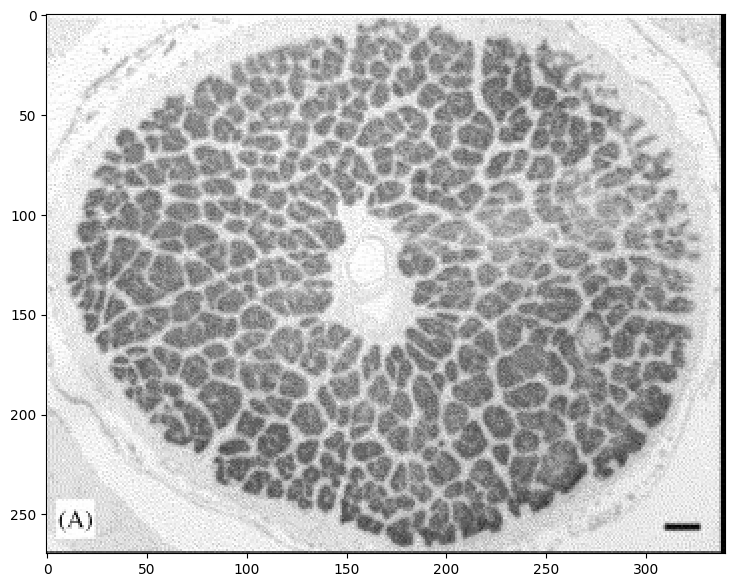

In [18]:
plt.imshow(axonsL)

In [19]:
hor = axonsL[1:-1, 1:-1] - axonsL[1:-1, :-2]
ver = axonsL[1:-1, 1:-1] - axonsL[:-2, 1:-1]
tot = np.sqrt(hor**2 + ver**2)

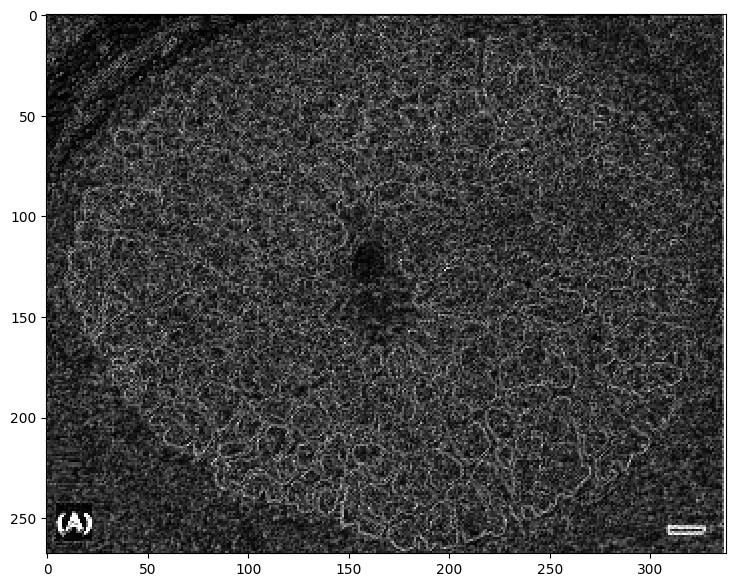

In [21]:
plt.imshow(tot, clim=[0, 0.5])

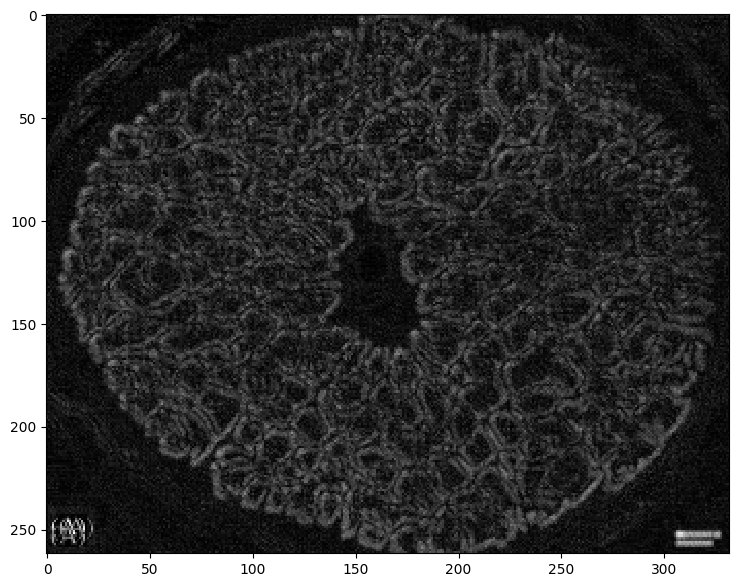

In [22]:
 # -- shift by several pixels
wid = 4

hor = axonsL[wid:-wid, wid:-wid] - axonsL[wid:-wid, :-2*wid]
ver = axonsL[wid:-wid, wid:-wid] - axonsL[:-2*wid, wid:-wid]
tot = np.sqrt(hor**2 + ver**2)

plt.imshow(tot)

---

### The Sobel Filter

Notice that this differencing process can also be defined in terms of a filter:

> ${\rm img}[1\colon, :] - {\rm img}[\colon-1, :] = \left[
  \begin{array}{cc}
  -1 & -1 \\
  1 & 1 \\
  \end{array}
\right]$

and

> ${\rm img}[:, 1\colon] - {\rm img}[:, \colon-1] = \left[
  \begin{array}{cc}
  -1 & 1 \\
  -1 & 1 \\
  \end{array}
\right]$

A more common filter is the **Sobel Filter**:

> $L_x = \left[
  \begin{array}{ccc}
  +1 & 0 & -1 \\
  +2 & 0 & -2 \\
  +1 & 0 & -1
  \end{array}
\right] * L, \  
L_y = \left[
  \begin{array}{ccc}
  +1 & +2 & +1 \\
   0 &  0 &  0 \\
  -1 & -2 & -1
  \end{array}
\right] * L$

with a magnitude given by $\sqrt{L_x^2 + L_y^2}$.


In [23]:
# -- define the Sobel filters
sx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
sy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

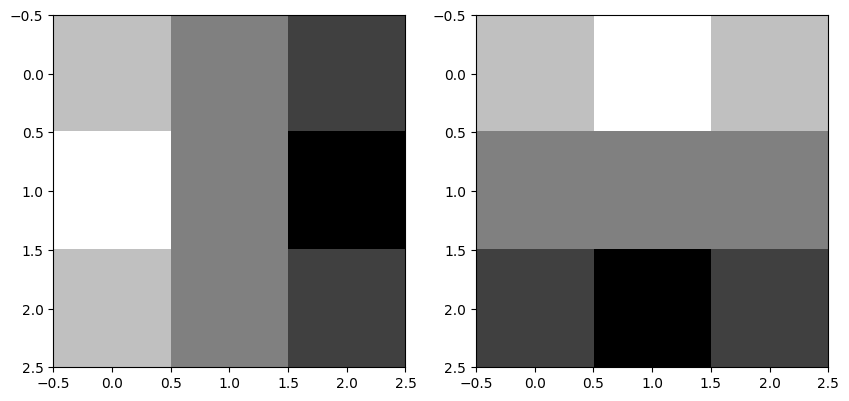

In [24]:
# -- visualize
fig, ax = plt.subplots(1, 2)
ax[0].imshow(sx)
ax[1].imshow(sy)
fig.show()

In [25]:
from scipy.signal import convolve2d

# -- we can do it ourselves
Lx = convolve2d(imgL, sx)
Ly = convolve2d(imgL, sy)
LL = np.sqrt(Lx**2 + Ly**2)

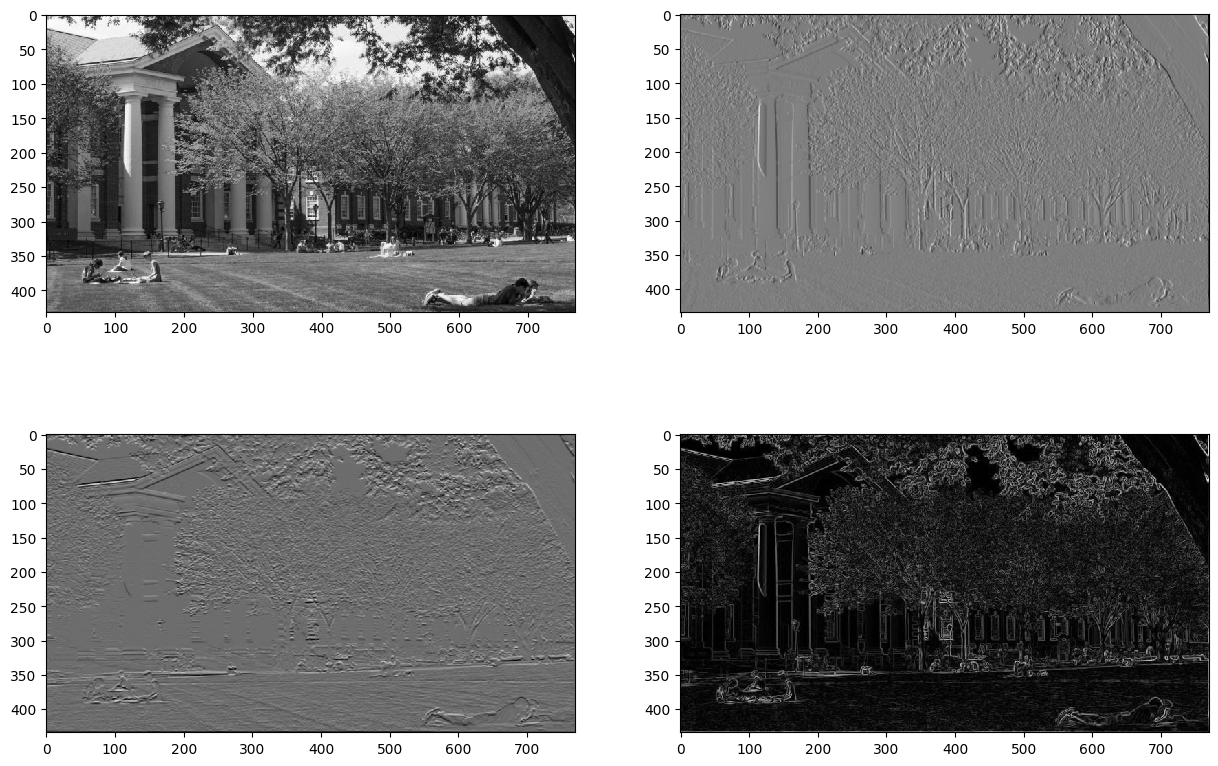

In [26]:
# -- plot it
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].imshow(imgL)
ax[0, 1].imshow(Lx)
ax[1, 0].imshow(Ly)
ax[1, 1].imshow(LL)

fig.show()

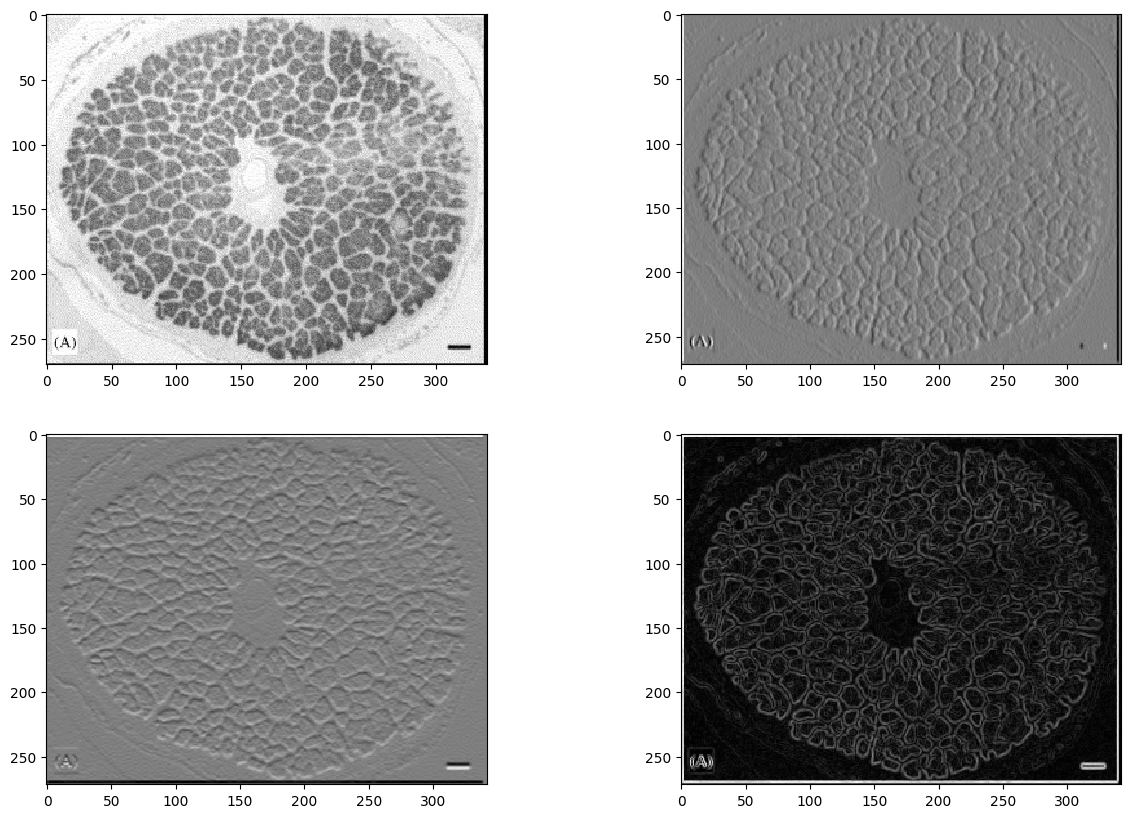

In [27]:
 # -- and on the axon image
Lx = convolve2d(axonsL, sx)
Ly = convolve2d(axonsL, sy)
LL = np.sqrt(Lx**2 + Ly**2)

# -- plot it
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].imshow(axonsL)
ax[0, 1].imshow(Lx)
ax[1, 0].imshow(Ly)
ax[1, 1].imshow(LL)

fig.show()